In [27]:
#importing relevant packages
from google.cloud import bigquery
from google.oauth2 import service_account
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from haversine import haversine, Unit
from sklearn.metrics import silhouette_samples, silhouette_score
import folium
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator
%matplotlib inline

In [28]:
file = 'geo_census.csv'
data = pd.read_csv(file)
data.head()

,d,s,p,pop,hhs,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


### Feature Engineering

In [29]:
#dropping columns with _pc in their names
for column in data.columns:
    if '_pc' in column:
        data.drop(column, axis = 1, inplace = True)
data.head()

,d,s,p,pop,hhs,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [30]:
#Renaming some columns for better understandability
data.rename(columns = {'d': 'district', 's': 'subcounty', 'p':'parish', 'pop':'population', 'hhs':'households'}, inplace = True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [31]:
#Drop rows with null values
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [32]:
#extracting x, y and z coordinates to replace latitude and longitude 
data['coord_x'] = np.cos(data['lat']) * np.cos(data['long'])
data['coord_y'] = np.cos(data['lat']) * np.sin(data['long'])
data['coord_z'] = np.sin(data['lat'])
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009),0.427272,0.834188,0.348667
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685),0.324676,0.899089,0.293641
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761


### data visualization

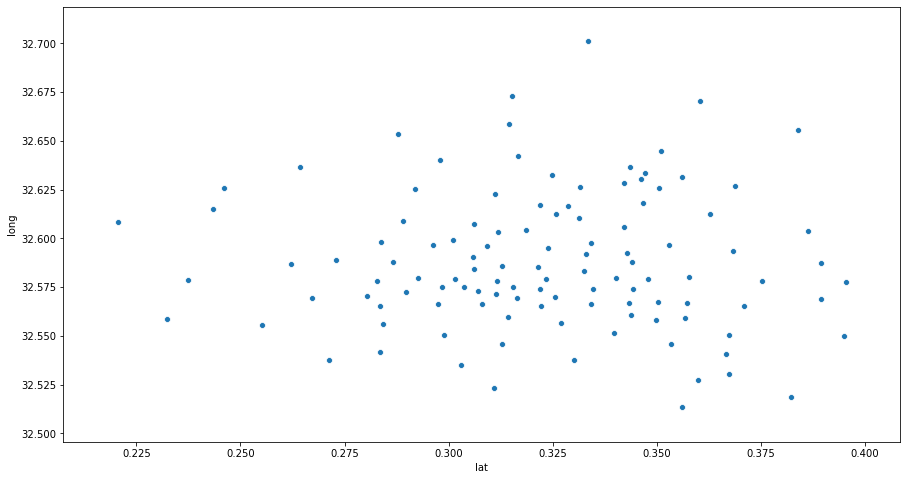

In [33]:
plt.figure(figsize = (15,8))
sns.scatterplot(data['lat'], data['long'])

In [34]:
# display coordinates on map of kampala
map_pickup = folium.Map( location=[0.3476,32.5825])
data.apply(lambda row:folium.CircleMarker(location=[row['lat'], row['long']] ).add_to(map_pickup), axis=1)
# optional: save the map.
map_pickup.save('map_pickup.html')
map_pickup

### Methods to be used

In [1]:
def scaling(data):
    '''
    Normaizes data
    '''
    data = StandardScaler().fit_transform(data)
    return data

In [82]:
def silhouette(data):
    '''
    determines optimal number of clusters using silhouette analysis
    '''
    silhouette_avgs = {}
    n_clusters = [x for x in range(2,100)]
    for n_clusters in n_clusters:

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_avgs[n_clusters] = silhouette_avg
    key_max = max(silhouette_avgs.keys(), key=(lambda k: silhouette_avgs[k]))
    print('Best silhoutte score is %f for %d' %(silhouette_avgs[key_max], key_max))

In [92]:
def kmeans(data, sensor_number):
    '''
    Clustering data using K-Means Model
    '''
    kmeans = KMeans(n_clusters=sensor_number).fit(data) 
    y_kmeans = kmeans.fit_predict(data)
    #data['cluster'] = y_kmeans
    return y_kmeans

In [65]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=0.3, shuffle=True)
    
def run_rf_model(X, y):
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(max_depth=2, random_state=0)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    print ('Random Forest Model')
    print_metrics(y_test, y_pred)
    
    
def print_metrics(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    accuracy =  accuracy_score(y_test, y_pred)
    #precision =  precision_score(y_test, y_pred, average=None)
    #recall =  recall_score(y_test, y_pred, average=None)
    
    print ('Accuracy: ', accuracy)
    #print ('Precision: ', precision)
    #print ('Recall: ', recall)
    
    
def run_logistic_model(X, y):
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(C=1e5)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    print ('Logistic Regression Model')
    print_metrics(y_test, y_pred)
    

### using most features

In [96]:
#data to be used for clustering
X = data[['coord_x', 'coord_y', 'coord_z', 'light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 
          'light_grass_per_km', 'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 
          'waste_burn_per_km', 'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 
          'pop_density', 'hhs_density', 'T123_per_sqkm']]
Xscaled = scaling(X)
silhouette(Xscaled)

Best silhoutte score is 0.624567 for 2


In [99]:
data_most = data.copy()
data_most['cluster'] = kmeans(Xscaled,20)

In [100]:
# Evaluation using logistic regression and random forest
y = data_most['cluster']
run_rf_model(X, y)
run_logistic_model(X, y)

Random Forest Model
Accuracy:  0.5142857142857142
Logistic Regression Model
Accuracy:  0.17142857142857143


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### using minimal features

In [102]:
Xmin = data[['cook_charc_per_km', 'cook_firewood_per_km', 'waste_burn_per_km', 'kitch_outside_built_per_km', 
             'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 'hhs_density']] 
Xmin_scaled = scaling(Xmin)
silhouette(Xmin_scaled)

Best silhoutte score is 0.624567 for 2


In [103]:
data_min = data.copy()
data_min['cluster'] = kmeans(Xmin_scaled,20)

# Evaluation
y = data_min['cluster']
run_rf_model(Xmin, y)
run_logistic_model(Xmin, y)

Random Forest Model
Accuracy:  0.42857142857142855
Logistic Regression Model
Accuracy:  0.3142857142857143


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### using min min features

In [104]:
Xminmin = data[['kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'cook_firewood_per_km', 'cook_charc_per_km', 
             'waste_burn_per_km','pop_density']]
Xminmin_scaled = scaling(Xminmin)
silhouette(Xminmin_scaled)

Best silhoutte score is 0.624567 for 2


In [105]:
data_minmin = data.copy()
data_minmin['cluster'] = kmeans(Xminmin_scaled,20)

# Evaluation
y = data_minmin['cluster']
run_rf_model(Xminmin, y)
run_logistic_model(Xminmin, y)

Random Forest Model
Accuracy:  0.4857142857142857
Logistic Regression Model
Accuracy:  0.45714285714285713


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Plotting

In [103]:
# Converting to a Geodataframe
data['geometry'] = data['geometry'].apply(wkt.loads)
data = gpd.GeoDataFrame(data, geometry = data['geometry'])
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,3.44,3.01,0.57,0.50,"POLYGON ((32.72674 0.32632, 32.72609 0.32735, ...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,6
1,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,10.85,9.75,0.19,0.17,"POLYGON ((32.52529 0.33488, 32.52572 0.33540, ...",POINT(32.5133620505223 0.356148577052009),0.427272,0.834188,0.348667,13
2,WAKISO,MASAJJA DIVISION,MASAJJA,48246,11998,22.7,32.587007,0.262109,5.033099,4.989443,...,13.27,12.08,0.14,0.13,"POLYGON ((32.57835 0.27637, 32.57830 0.27641, ...",POINT(32.587007394156 0.262108604793302),0.375865,0.889710,0.259118,12
3,WAKISO,MASAJJA DIVISION,BUSABALA,39045,9642,22.1,32.608197,0.220525,21.154149,20.969131,...,7.71,6.79,0.42,0.37,"POLYGON ((32.57885 0.25599, 32.57877 0.25577, ...",POINT(32.6081969296703 0.220524805457365),0.360602,0.906708,0.218742,13
4,WAKISO,MASAJJA DIVISION,NAMASUBA,29957,7659,30.0,32.569393,0.267224,2.368842,2.348438,...,18.13,12.76,0.14,0.10,"POLYGON ((32.57061 0.27558, 32.57058 0.27569, ...",POINT(32.5693931075797 0.267223906114203),0.390935,0.881728,0.264055,12


### Select one parish per cluster

In [33]:
select_data = data.sample(frac=1).reset_index(drop=True)
select_data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,KAMPALA,KAWEMPE DIVISION,KIKAAYA,31685,8332,27.0,32.593329,0.368274,4.007762,3.972914,...,7905.91,2078.97,3.80,13.96,12.36,0.18,0.16,"POLYGON ((32.59927 0.37746, 32.59901 0.37745, ...",POINT(32.5933292568583 0.368274177936481),8
1,KAMPALA,NAKAWA DIVISION,MUTUNGO,64663,17343,28.4,32.642221,0.316613,4.482538,4.442810,...,14425.53,3869.01,3.73,14.72,12.86,0.10,0.09,"POLYGON ((32.62946 0.31762, 32.62944 0.31738, ...",POINT(32.6422210737128 0.316613228968423),51
2,KAMPALA,NAKAWA DIVISION,ITEK,571,6,50.0,32.630562,0.346092,0.121401,0.120330,...,4703.42,49.42,95.17,29.21,29.21,0.62,0.62,"POLYGON ((32.63214 0.34675, 32.63198 0.34697, ...",POINT(32.6305618353691 0.346092338257564),5
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON ((32.63901 0.28775, 32.63904 0.28776, ...",POINT(32.6401789189264 0.298033199468685),43
4,KAMPALA,CENTRAL DIVISION,INDUSTRIAL AREA,645,259,13.9,32.604293,0.318469,1.708273,1.693356,...,377.57,151.62,2.49,17.71,10.57,4.69,2.80,"POLYGON ((32.59339 0.31648, 32.59372 0.31606, ...",POINT(32.6042931703541 0.318468755012221),57


In [34]:
select_data= select_data.drop_duplicates('cluster', keep = 'last')
select_data.shape

(60, 45)

In [35]:
select_data.columns

Index(['district', 'subcounty', 'parish', 'population', 'households',
       'fem_hhs', 'long', 'lat', 'km2', 'area', 'perimeter', 'T123',
       'not_T123', 'light_gas_per_km', 'light_lpg_per_km',
       'light_biogas_per_km', 'light_par_lantern_per_km',
       'light_par_tadooba_per_km', 'light_candles_per_km',
       'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km',
       'cook_elec_therm_per_km', 'cook_gas_per_km', 'cook_lpg_per_km',
       'cook_biogas_per_km', 'cook_par_lantern_per_km', 'cook_charc_per_km',
       'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km',
       'waste_burn_per_km', 'kitch_outside_built_per_km',
       'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density',
       'hhs_density', 'pop_per_hhs', 'T123_per_sqkm', 'not_T123_per_sqkm',
       'T123_per_person', 'not_T123_per_person', 'geometry', 'centroid',
       'cluster'],
      dtype='object')

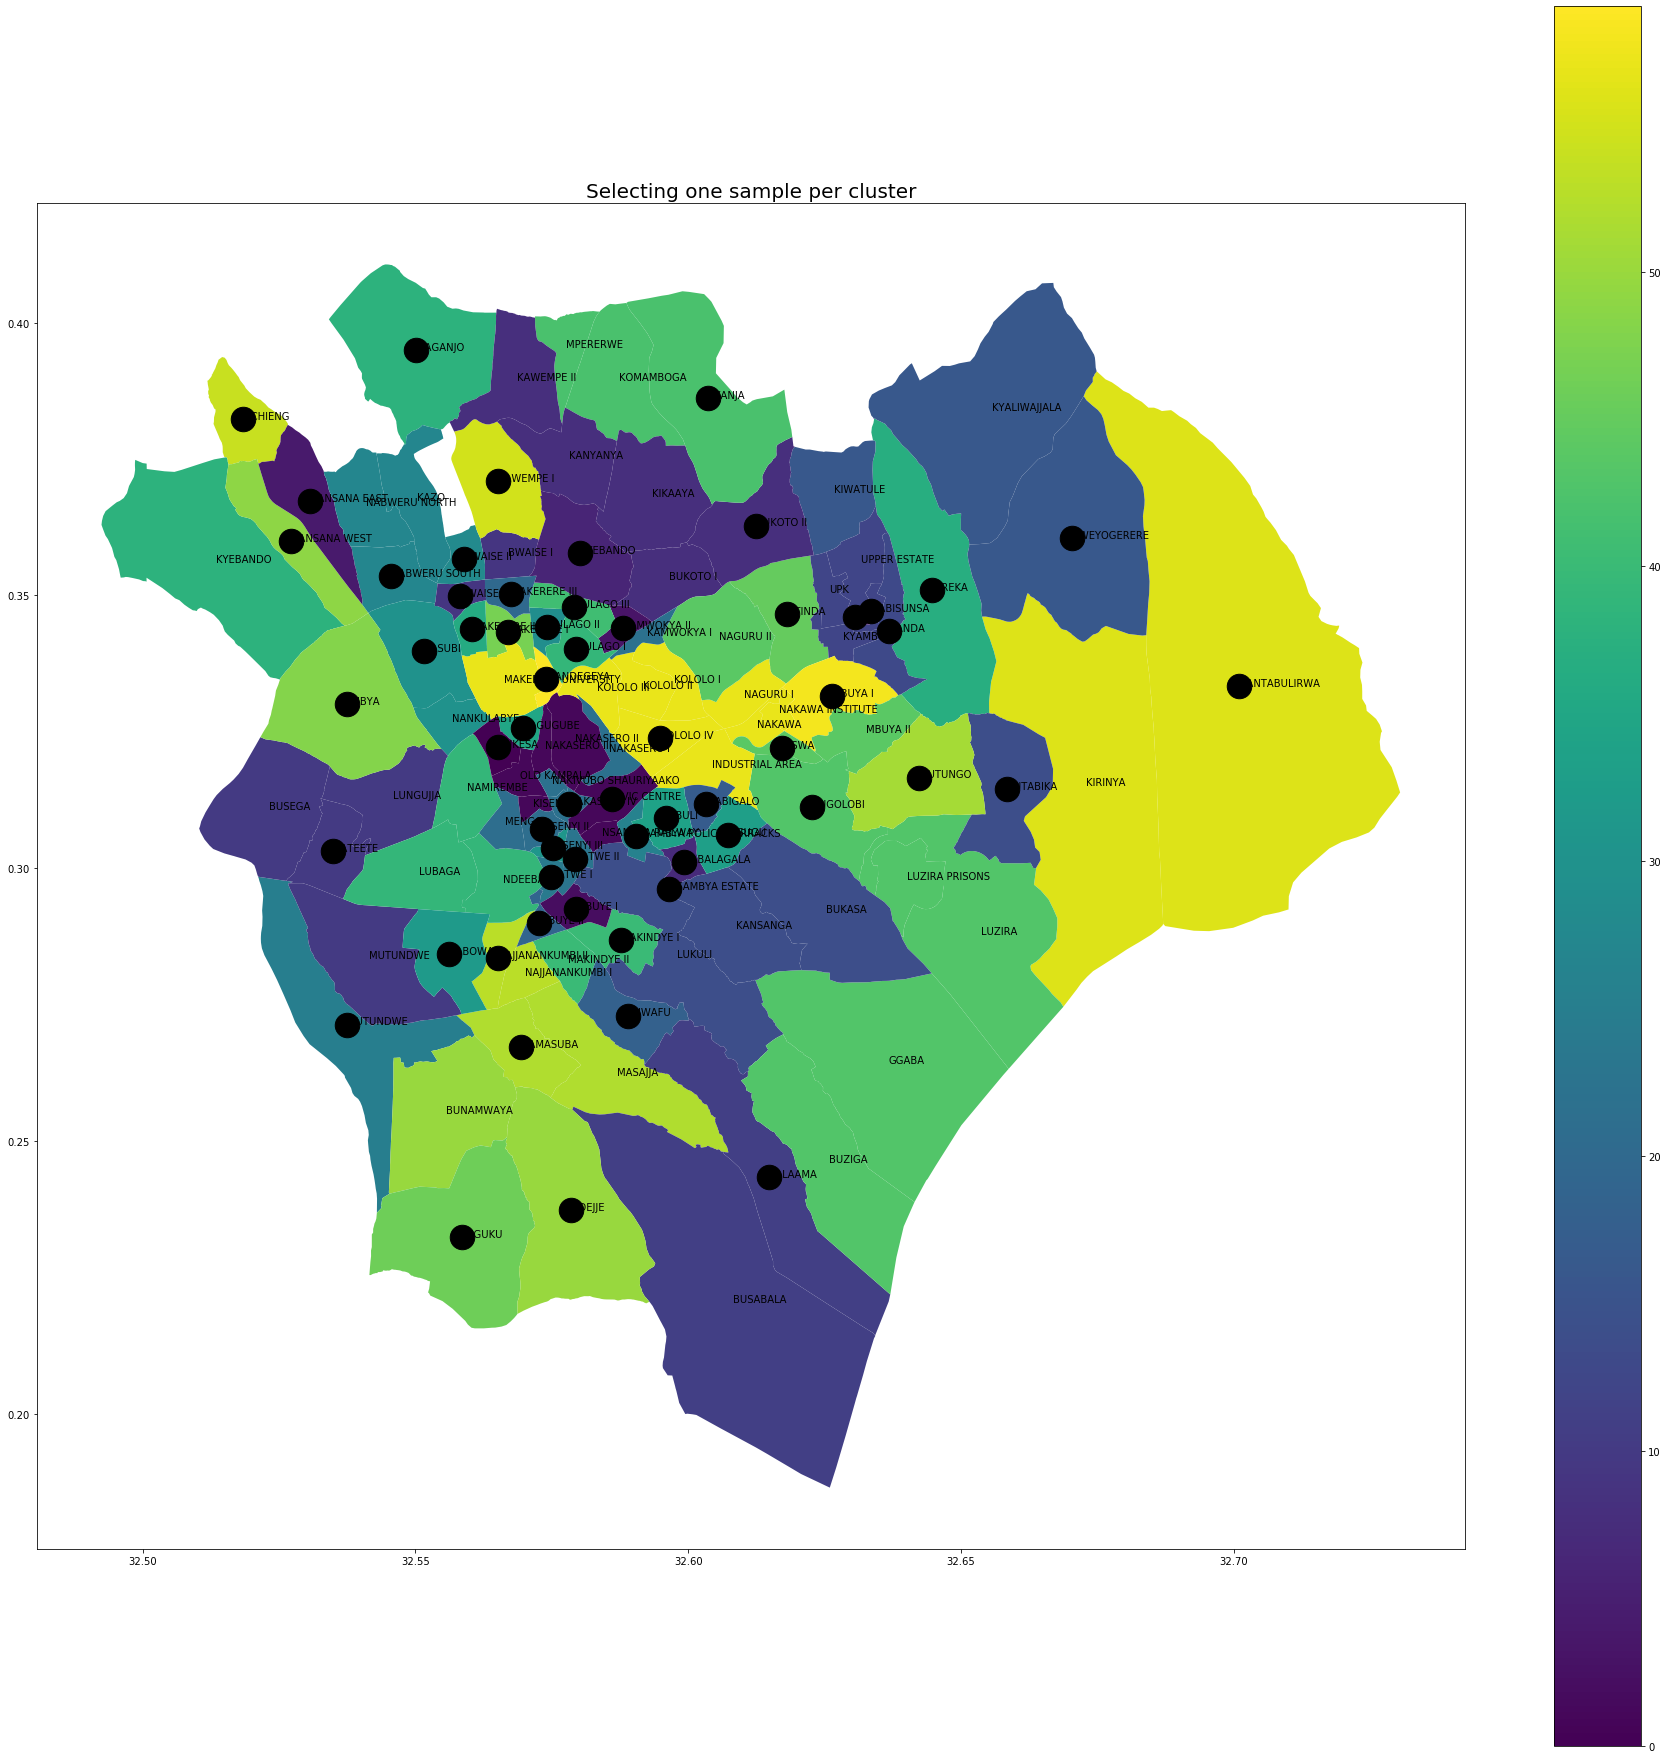

In [36]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Selecting one sample per cluster' 
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
#plt.scatter(data_cluster.long, data_cluster.lat, s=600, c='k')
plt.scatter(select_data.long, select_data.lat, s=600, c='k')
plt.show()
fig.savefig('First Sensor Locations.png')

### In the case of new sensors

In [37]:
all_parish_locations = data[['long', 'lat', 'cluster']] #dataframe of all parish geocoordinates
sensor_locations =select_data[['long', 'lat', 'cluster']]#dataframe of all current sensor locations

In [38]:
#creating dataframe of parishes without sensors
remainder_locations = pd.concat([all_parish_locations, sensor_locations, sensor_locations]).drop_duplicates(keep=False)
remainder_locations.head()

,long,lat,cluster
1,32.513362,0.356149,38
2,32.587007,0.262109,52
3,32.608197,0.220525,11
7,32.550280,0.367407,27
12,32.555615,0.255076,50


In [39]:
remainder_locations.shape

(54, 3)

In [40]:
#geocoordinates of all parishes, where sensors are located and parishes without sensors
all_parish_points = [xy for xy in zip(all_parish_locations.long, all_parish_locations.lat)] 
sensor_points = [xy for xy in zip(sensor_locations.long, sensor_locations.lat)] 
remainder_points = [xy for xy in zip(remainder_locations.long, remainder_locations.lat)]

In [41]:
#Calculating the distance between the centroids of the parishes and the locations that already have sensors
distances_dict = dict() #empty dictionary that will contain geocoordinates(parishes) as keys and distances as values        

In [42]:
for point in remainder_points:
    final_distance = 0
    for sensor_point in sensor_points:
        distance = haversine(point, sensor_point)
        final_distance+=distance
    distances_dict[point] = final_distance

In [43]:
remainder_locations['largest_distance'] = distances_dict.values()
remainder_locations.head()

,long,lat,cluster,largest_distance
1,32.513362,0.356149,38,558.723124
2,32.587007,0.262109,52,421.240835
3,32.608197,0.220525,11,641.474447
7,32.550280,0.367407,27,413.528999
12,32.555615,0.255076,50,489.768444


In [44]:
#To get the largest distance in each cluster
max_cluster = remainder_locations.groupby(['cluster']).max()
max_cluster

,long,lat,largest_distance
cluster,,,
1,32.584200,0.323343,284.772519
8,32.596444,0.389494,461.267199
9,32.567034,0.357371,337.655417
10,32.545858,0.312871,483.031406
11,32.608197,0.220525,641.474447
12,32.631631,0.356111,432.398400
14,32.625246,0.291906,408.429981
16,32.655741,0.384000,621.958139
21,32.566487,0.308032,299.027118


In [45]:
n = 3 #number of new sensors to be placed

In [46]:
#getting parishes with the n largest distances
largest = max_cluster.nlargest(n, ['largest_distance']) 
largest

,long,lat,largest_distance
cluster,,,
11,32.608197,0.220525,641.474447
16,32.655741,0.384000,621.958139
56,32.672968,0.315175,621.551710


In [47]:
latitudes =[]
longitudes = []
for distance in largest['largest_distance']:
    latitude = remainder_locations.loc[remainder_locations['largest_distance']==distance, 'lat'].iloc[0]
    longitude = remainder_locations.loc[remainder_locations['largest_distance']==distance, 'long'].iloc[0]
    latitudes.append(latitude)
    longitudes.append(longitude)

In [48]:
max_latitudes = pd.Series(latitudes)
max_longitudes = pd.Series(longitudes)
max_df = pd.concat([max_latitudes, max_longitudes], axis=1)
max_df.columns=['latitude', 'longitude']
max_df

,latitude,longitude
0,0.220525,32.608197
1,0.384000,32.655741
2,0.315175,32.672968


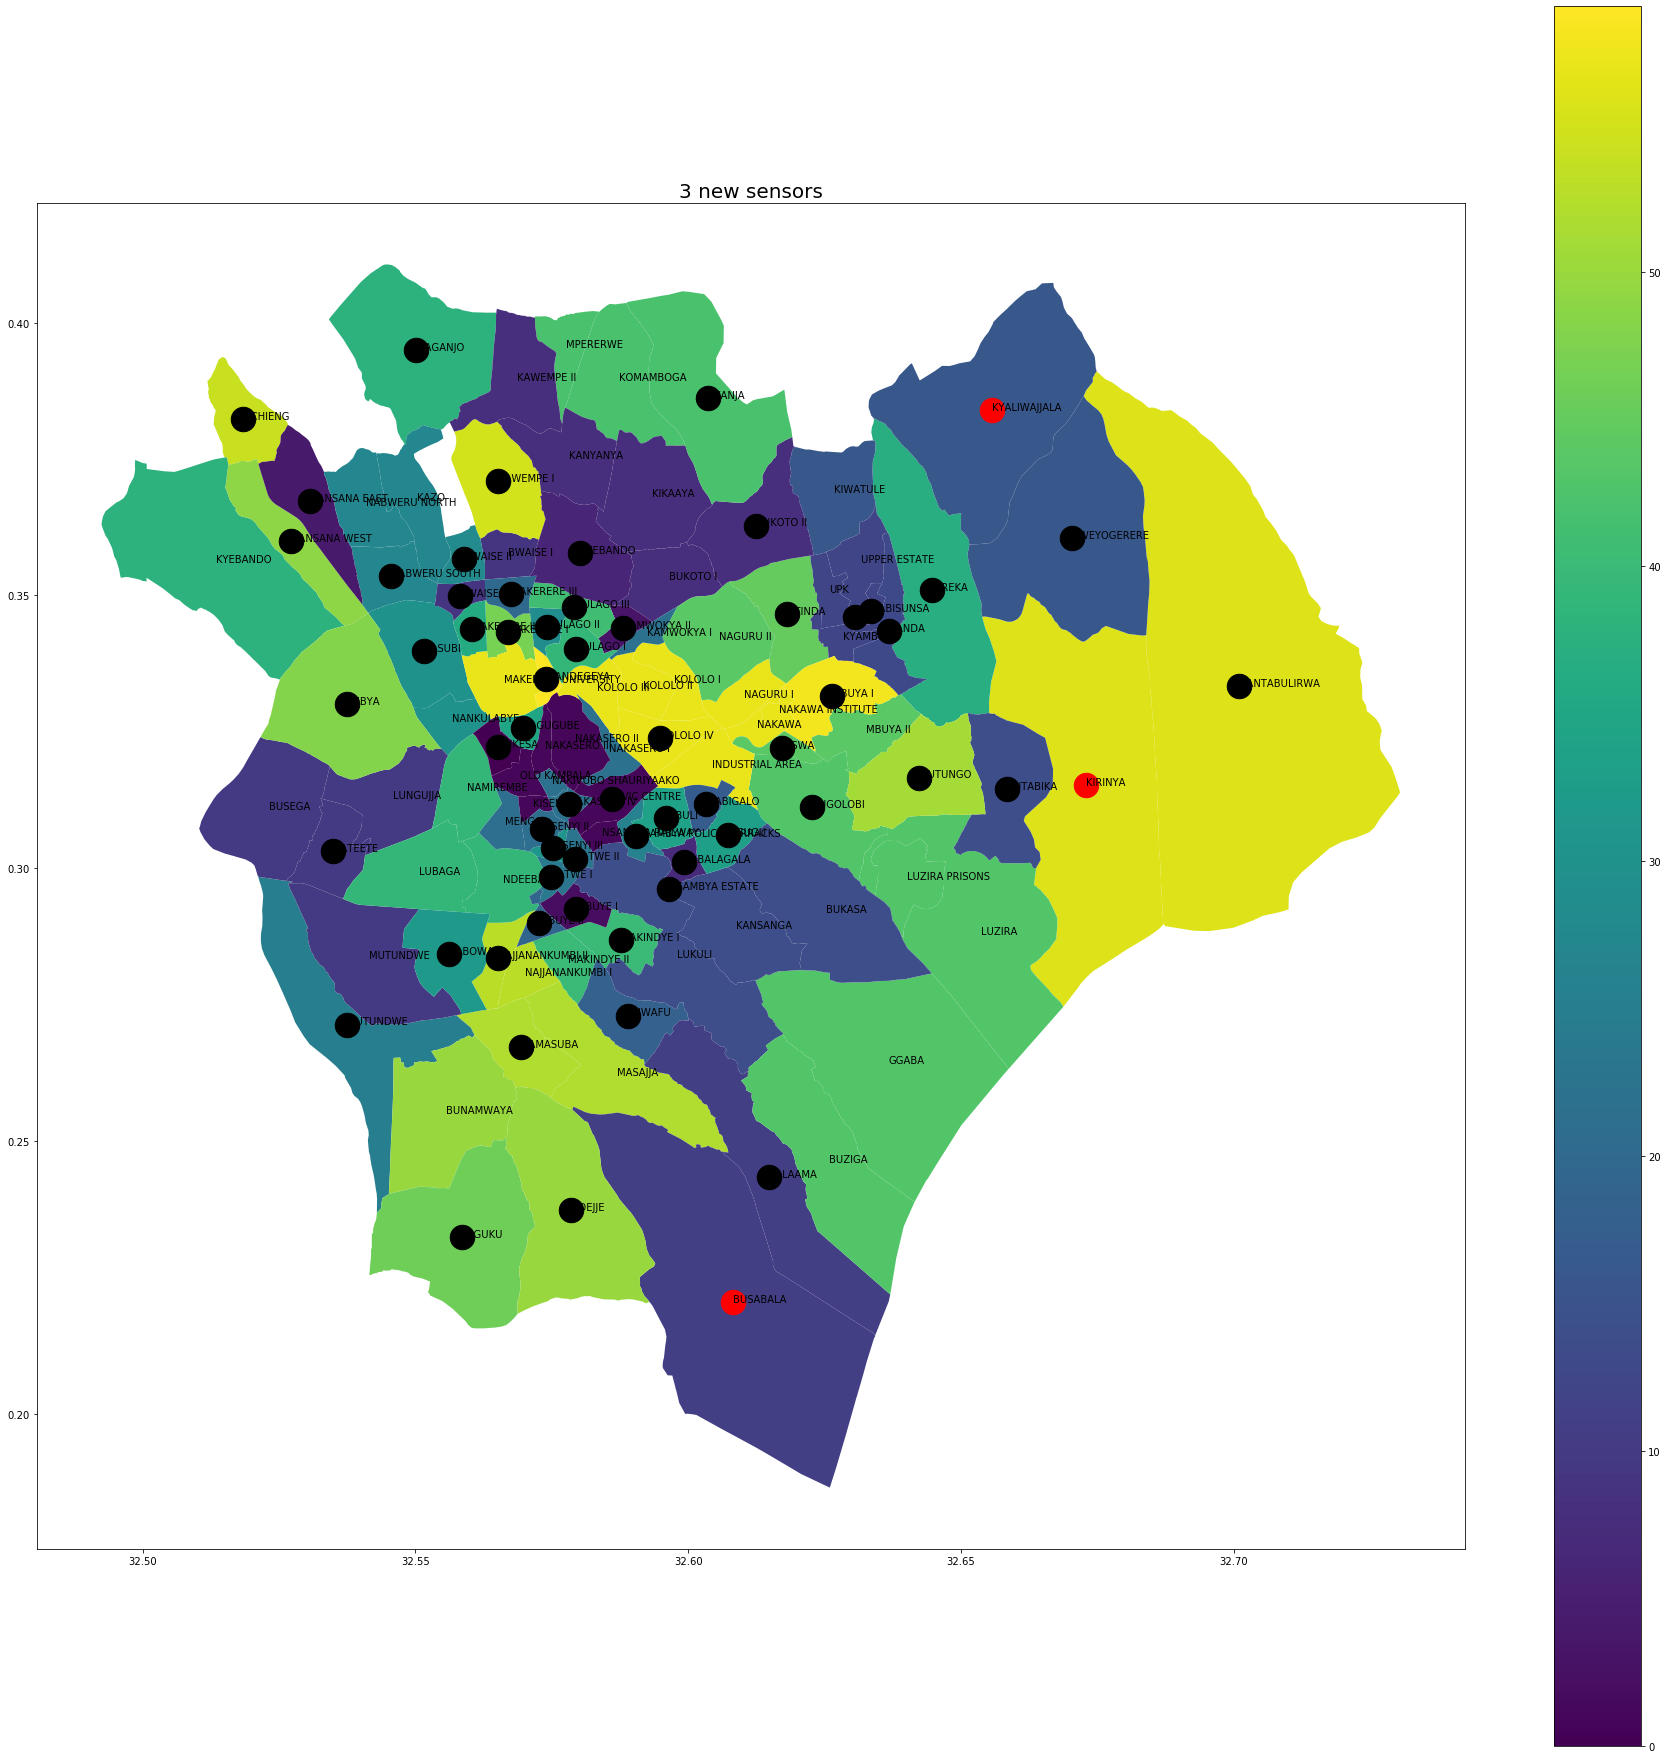

In [49]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title = '%d new sensors' %n 
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))

plt.scatter(select_data.long, select_data.lat, s=600, c='k')
plt.scatter(max_df.longitude, max_df.latitude, s=600, c='r')

plt.show()
fig.savefig('New sensors.png')